In [2]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras_self_attention
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.models import Model
from keras.activations import softmax
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations
from keras_self_attention import SeqSelfAttention
from scipy.stats import entropy
import keras

%matplotlib inline

### 1. Import Files: 

In [3]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print('Number of Files: '+str(n_files))

Number of Files: 11


### 2. Preprocessing of Data 

In [4]:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa]
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon]
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ..."
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä]


In [5]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=10000)
t.fit_on_texts(docs)

In [6]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df['Previous Utterance'] = df['Utterance'].shift(1)
    df['Next Utterance'] = df['Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


In [7]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

### 3. Import Models

In [35]:
# Import Models:
from keras.models import load_model
local_model_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/evaluation'
models_path = []
models = []
global max_length
# r=root, d=directories, f = files
for r, d, f in os.walk(local_model_path):
    for file in f:
        if '.h5' in file:
            print(file)
            models_path.append(os.path.join(r, file))
            models.append(load_model(os.path.join(r, file), custom_objects={"softMaxAxis1": softMaxAxis1}))
            #models.append(load_model(os.path.join(r, file), custom_objects=SeqSelfAttention.get_custom_objects()))

pe_enc_simple_at.h5


### 4. Entropy Analysis:

In [36]:
def obtain_entropy(models):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    max_length = 20
    n_models = len(models)
    dics_test = {}
    dics_train = {}
    for model in models:
        dics_test[model.name] = {}
        dics_train[model.name] = {}
    for couple in couples:
        #Split Training and Test Set
        training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
        all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase','Utterance',
                                                                'Previous Utterance', 'Next Utterance']].dropna()

        X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_train = all_data_train['Relative Position']
        X_n_train = all_data_train['Number of Words']

        y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')

        test_dfs = [dfs[i] for i in couple]

        all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase','Utterance',
                                                                'Previous Utterance', 'Next Utterance']].dropna()

        X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_test = all_data_test['Relative Position']
        X_n_test = all_data_test['Number of Words']

        y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')
    
        for model in models:
            print('Evaluating Model '+str(model.name))
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5')
            
            #Save Entropy: Test
    
            Entropy = pd.DataFrame(model.predict({'p_utterance_input': X_pu_test,
                                        'utterance_input': X_u_test,
                                        'n_utterance_input': X_nu_test,
                                        'rel_position_input': X_r_test,
                                        'n_words_input': X_n_test}))

            Entropy['S'] = Entropy.apply(lambda row: entropy(row), axis = 1)
        
            get_attetion_layer_output = K.function([model.layers[0].input,model.layers[1].input,model.layers[2].input],
                                              [model.layers[7].output])
    
            att = get_attetion_layer_output([X_pu_test,X_u_test,X_nu_test])[0]
    

            Entropy['Attention S'] = Entropy.apply(lambda row: entropy(att[row.name])[0], axis = 1)


            Entropy['Utterance'] = list(all_data_test['Utterance'])
            Entropy['Previous Utterance'] = list(all_data_test['Previous Utterance'])
            Entropy['Next Utterance'] = list(all_data_test['Next Utterance'])

            
            Entropy['Real'] = y_test.argmax(axis=-1)
            Entropy['Pred'] = model.predict({'p_utterance_input': X_pu_test,
                                        'utterance_input': X_u_test,
                                        'n_utterance_input': X_nu_test,
                                        'rel_position_input': X_r_test,
                                        'n_words_input': X_n_test}).argmax(axis=-1)
            Entropy['Pred 2'] = model.predict({'p_utterance_input': X_pu_test,
                                        'utterance_input': X_u_test,
                                        'n_utterance_input': X_nu_test,
                                        'rel_position_input': X_r_test,
                                        'n_words_input': X_n_test}).argsort(axis=-1)[:,-2]
            Entropy = Entropy.astype('object')
    
            Entropy['Attention'] = list(att.reshape(len(Entropy),60))
            
            dics_test[model.name][str(couple)] = Entropy
            
           
        
    return(dics_test,dics_train)

In [37]:
entropy_dic = obtain_entropy(models)

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Model pe_enc_simple_at
Evaluating Mod

In [38]:
entropy_df = pd.concat(entropy_dic[0]['pe_enc_simple_at'].values(),ignore_index = True)

Empty DataFrame
Columns: []
Index: []


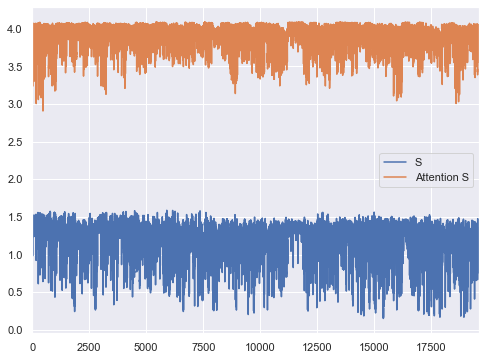

In [39]:
entropy_df[['S','Attention S']].plot(figsize= (8,6))
print(entropy_df[['S','Attention S']].corr())

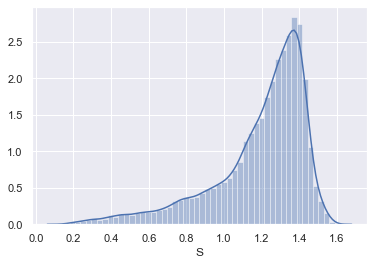

In [40]:
ax = sns.distplot(entropy_df['S'])

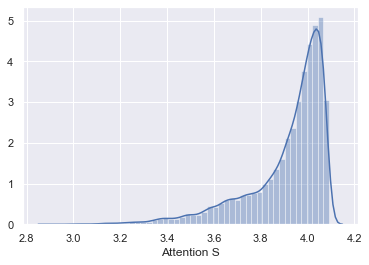

In [41]:
ax = sns.distplot(entropy_df['Attention S'])

In [15]:
bien_seguro = []
bien_inseguro = []
mal_seguro = []
mal_inseguro = []
for i in range(5):
    df1_local = entropy_df.loc[(entropy_df['Real']==i) & (entropy_df['Real']==entropy_df['Pred']) & (entropy_df['S']<1)]
    bien_seguro.append(df1_local)
    
    df2_local = entropy_df.loc[(entropy_df['Real']==i) & (entropy_df['Real']==entropy_df['Pred']) & (entropy_df['S']>=1)]
    bien_inseguro.append(df2_local)
    
    df3_local = entropy_df.loc[(entropy_df['Real']==i) & (entropy_df['Real']!=entropy_df['Pred']) & (entropy_df['S']<1)]
    mal_seguro.append(df3_local)
    
    df4_local = entropy_df.loc[(entropy_df['Real']==i) & (entropy_df['Real']!=entropy_df['Pred']) & (entropy_df['S']>=1)]
    mal_inseguro.append(df4_local)
    
bien_seguro_df = pd.concat(bien_seguro)
mal_seguro_df = pd.concat(mal_seguro)
bien_inseguro_df = pd.concat(bien_inseguro)
mal_inseguro_df = pd.concat(mal_inseguro)

In [16]:
print(len(bien_seguro_df))
print(len(bien_inseguro_df))
print(len(mal_seguro_df))
print(len(mal_inseguro_df))

3698
7455
1340
7087


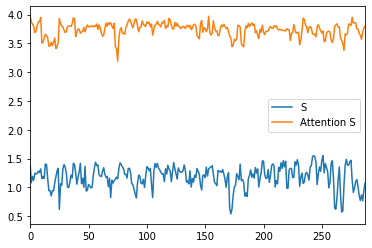

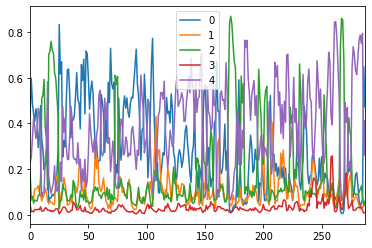

In [17]:
entropy_df.head(len(dfs[0]))[['S','Attention S']].plot()
entropy_df.head(len(dfs[0]))[[0,1,2,3,4]].plot()

### 4. Attention Visualization:

[Epäselvä puheenvuoro] [ajavat skriptin uudestaan one thousand x five hundred, path length two hundred and sixty-seven.two hundred and eighty-eight...]  Täh ? Oota. ([Ofour:] Niin nyt se on taas lyhyempi. Ku se on niin satunnainen niin...)     Nii, ja jos se on... [epäselvä]. [ajavat skriptin uudestaan one thousand x five hundred, path length one thousand, two hundred


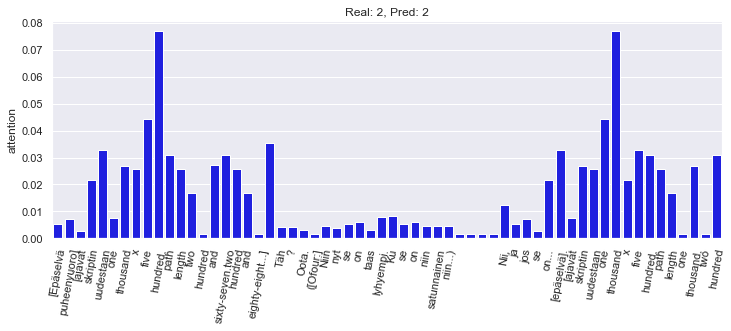

In [19]:
i = 10
selected_df = bien_seguro[2].sort_values('S',ascending=True).reset_index(drop=True)
attention = selected_df['Attention'][i].reshape(60,1)
plot_df = pd.DataFrame(attention)
putt = selected_df['Previous Utterance'][i].split()[:20]+['']*max(20 - len(selected_df['Previous Utterance'][i].split()),0)
utt = selected_df['Utterance'][i].split()[:20]+[''] * max(20 - len(selected_df['Utterance'][i].split()),0)
nutt = selected_df['Next Utterance'][i].split()[:20]+[''] * max(20 - len(selected_df['Next Utterance'][i].split()),0)
list_words = putt+utt+nutt
plot_df['word'] = list_words
plot_df.columns = ['attention','word']
print(' '.join(list_words))
plt.figure(figsize = (12,4))
sns.set(font_scale=1)
#ax = sns.heatmap(pd.DataFrame(layer_output[i]), cmap="YlGnBu", yticklabels=list_words,vmax=0.1,vmin=0)
ax = sns.barplot(x=plot_df.index, y=plot_df.attention, data=plot_df, orient='v',color="blue")
ax.set_xticklabels(plot_df.word, rotation=80)
ax.set_title('Real: '+str(selected_df['Real'][i])+', Pred: '+str(selected_df['Pred'][i]))
plt.savefig('atention_output_'+str(i),bbox_inches = 'tight')

[Lukee tehtävänantoa.]                   [Katsoo skriptin tulostetta.] joo.                 Eli jos me muutetaan tätä ...[epäselvä]. ([Oone:] Ännää.) Ännää. Reippaasti.          


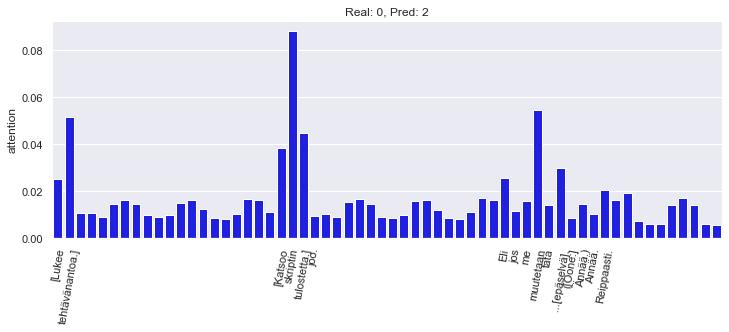

In [56]:
attention = entropy_df.loc[entropy_df['Utterance']=='[Katsoo skriptin tulostetta.] joo.'].iloc[-1]['Attention'].reshape(60,1)
a = entropy_df.loc[entropy_df['Utterance']=='[Katsoo skriptin tulostetta.] joo.'].iloc[-1]
plot_df = pd.DataFrame(attention)
putt = a['Previous Utterance'].split()[:20]+['']*max(20 - len(a['Previous Utterance'].split()),0)
utt = a['Utterance'].split()[:20]+[''] * max(20 - len(a['Utterance'].split()),0)
nutt = a['Next Utterance'].split()[:20]+[''] * max(20 - len(a['Next Utterance'].split()),0)
list_words = putt+utt+nutt
plot_df['word'] = list_words
plot_df.columns = ['attention','word']
print(' '.join(list_words))
plt.figure(figsize = (12,4))
sns.set(font_scale=1)
#ax = sns.heatmap(pd.DataFrame(layer_output[i]), cmap="YlGnBu", yticklabels=list_words,vmax=0.1,vmin=0)
ax = sns.barplot(x=plot_df.index, y=plot_df.attention, data=plot_df, orient='v',color="blue")
ax.set_xticklabels(plot_df.word, rotation=80)
ax.set_title('Real: '+str(a['Real'])+', Pred: '+str(a['Pred']))
plt.savefig('atention_output_'+str(i),bbox_inches = 'tight')

[Lukee tehtävänantoa.]                   [Katsoo skriptin tulostetta.] joo.                 Eli jos me muutetaan tätä ...[epäselvä]. ([Oone:] Ännää.) Ännää. Reippaasti.          


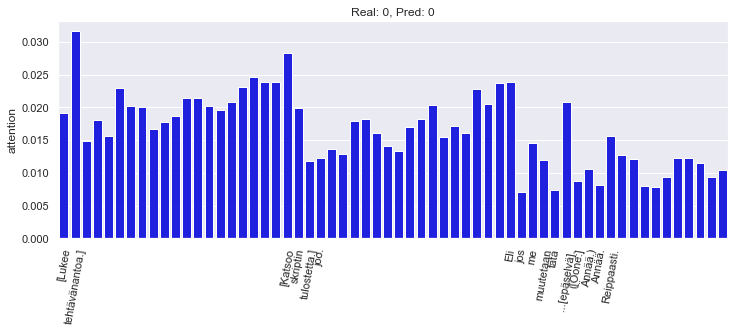

In [57]:
attention = entropy_df.loc[entropy_df['Utterance']=='[Katsoo skriptin tulostetta.] joo.'].iloc[0]['Attention'].reshape(60,1)
a = entropy_df.loc[entropy_df['Utterance']=='[Katsoo skriptin tulostetta.] joo.'].iloc[0]
plot_df = pd.DataFrame(attention)
putt = a['Previous Utterance'].split()[:20]+['']*max(20 - len(a['Previous Utterance'].split()),0)
utt = a['Utterance'].split()[:20]+[''] * max(20 - len(a['Utterance'].split()),0)
nutt = a['Next Utterance'].split()[:20]+[''] * max(20 - len(a['Next Utterance'].split()),0)
list_words = putt+utt+nutt
plot_df['word'] = list_words
plot_df.columns = ['attention','word']
print(' '.join(list_words))
plt.figure(figsize = (12,4))
sns.set(font_scale=1)
#ax = sns.heatmap(pd.DataFrame(layer_output[i]), cmap="YlGnBu", yticklabels=list_words,vmax=0.1,vmin=0)
ax = sns.barplot(x=plot_df.index, y=plot_df.attention, data=plot_df, orient='v',color="blue")
ax.set_xticklabels(plot_df.word, rotation=80)
ax.set_title('Real: '+str(a['Real'])+', Pred: '+str(a['Pred']))
plt.savefig('atention_output_'+str(i),bbox_inches = 'tight')

In [44]:
mal_inseguro_df.loc['']

,0,1,2,3,4,S,Attention S,Utterance,Previous Utterance,Next Utterance,Real,Pred,Pred 2,Attention
7,0.294933,0.128412,0.0856246,0.0252458,0.465784,1.28289,3.87508,Ton verran. Ai pitää muuten kattoo etukäteen s...,Jaaha.,[Katsovat jäljellä olevia tehtäviä ja toteavat...,0,4,0,"[0.02267297, 0.007827919, 0.007827919, 0.00782..."
8,0.344274,0.101177,0.0862121,0.0231216,0.445215,1.25756,3.87879,[Katsovat jäljellä olevia tehtäviä ja toteavat...,Ton verran. Ai pitää muuten kattoo etukäteen s...,[Lukee tehtävänantoa.],0,4,0,"[0.028417762, 0.04026129, 0.03899824, 0.021064..."
10,0.330179,0.0609227,0.511062,0.0173739,0.0804618,1.15258,3.50524,[Lukee tehtävänantoa.],[Lukee tehtävänantoa.],[Katsoo skriptin tulostetta.] joo.,0,2,0,"[0.03631264, 0.023073928, 0.009589333, 0.00958..."
11,0.286996,0.0765837,0.521699,0.0175213,0.0971996,1.19191,3.51756,[Katsoo skriptin tulostetta.] joo.,[Lukee tehtävänantoa.],Eli jos me muutetaan tätä ...[epäselvä]. ([Oon...,0,2,0,"[0.030163245, 0.019166455, 0.0079654185, 0.007..."
12,0.198362,0.0874916,0.592446,0.0207943,0.100906,1.15615,3.59376,Eli jos me muutetaan tätä ...[epäselvä]. ([Oon...,[Katsoo skriptin tulostetta.] joo.,[epäselvä] ...kuitenkin niinku alle miljoonass...,0,2,0,"[0.012590413, 0.037372515, 0.112315096, 0.0216..."
13,0.222808,0.117496,0.383693,0.0314499,0.244554,1.40688,3.65848,[epäselvä] ...kuitenkin niinku alle miljoonass...,Eli jos me muutetaan tätä ...[epäselvä]. ([Oon...,[epäselvä] ...muuttaaks se sama... [epäselvä].,0,2,4,"[0.018398326, 0.01882857, 0.015630245, 0.03097..."
14,0.238414,0.0943619,0.339136,0.0302781,0.29781,1.39793,3.63039,[epäselvä] ...muuttaaks se sama... [epäselvä].,[epäselvä] ...kuitenkin niinku alle miljoonass...,[epäselvä] ...sen verran pieni ...[epäselvä].,0,2,4,"[0.025291665, 0.012719347, 0.030609779, 0.0436..."
15,0.222788,0.0627861,0.110177,0.022036,0.582213,1.15033,3.59463,[epäselvä] ...sen verran pieni ...[epäselvä].,[epäselvä] ...muuttaaks se sama... [epäselvä].,Joo. [epäselvä],0,4,0,"[0.0734039, 0.0081188865, 0.031279165, 0.09491..."
24,0.285522,0.126189,0.438061,0.0232917,0.126936,1.33024,3.52232,Mitkä ovat tehtävänannon keskeiset fysiikan kä...,"No, se on tos. Tää on aina vähän eri suuntaan ...","[epäselvä]. Että, no mitä me muuta ne. ([Otwo:...",0,2,0,"[0.015916813, 0.01869718, 0.0058445963, 0.0114..."
28,0.253521,0.104548,0.135289,0.0319822,0.47466,1.31841,3.791,Alussa ollaan origossa.,Meeppä alaspäin... [epäselvä].,"(Se on varmaan yhtä pieni, kun...) [Epäselvä l...",0,4,0,"[0.010172502, 0.034120172, 0.09197091, 0.01017..."
